Classes: ['Healthy', 'RSC', 'RSM', 'TMB', 'Thrips', 'jassid', 'looper']
Dataset sizes: {'train': 12980, 'val': 3245}
Using device: cuda:0


/home/idrone2/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/idrone2/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/25
----------
Train Loss: 1.3074 Acc: 0.5039
Val Loss: 1.1590 Acc: 0.5803

Epoch 2/25
----------
Train Loss: 1.1407 Acc: 0.5762
Val Loss: 1.0961 Acc: 0.6055

Epoch 3/25
----------
Train Loss: 1.1196 Acc: 0.5824
Val Loss: 1.1016 Acc: 0.5960

Epoch 4/25
----------
Train Loss: 1.0981 Acc: 0.5953
Val Loss: 1.0944 Acc: 0.5908

Epoch 5/25
----------
Train Loss: 1.0955 Acc: 0.5908
Val Loss: 1.0675 Acc: 0.6092

Epoch 6/25
----------
Train Loss: 1.0916 Acc: 0.5981
Val Loss: 1.1492 Acc: 0.5720

Epoch 7/25
----------
Train Loss: 1.0834 Acc: 0.5999
Val Loss: 1.0797 Acc: 0.6059

Epoch 8/25
----------
Train Loss: 1.0919 Acc: 0.5995
Val Loss: 1.0746 Acc: 0.6031

Epoch 9/25
----------
Train Loss: 1.0904 Acc: 0.5935
Val Loss: 1.0610 Acc: 0.6111

Epoch 10/25
----------
Train Loss: 1.0856 Acc: 0.5984
Val Loss: 1.0821 Acc: 0.5935

Epoch 11/25
----------
Train Loss: 1.0771 Acc: 0.6032
Val Loss: 1.1570 Acc: 0.5584

Epoch 12/25
----------
Train Loss: 1.0837 Acc: 0.5956
Val Loss: 1.0951 Acc: 0.6012

E

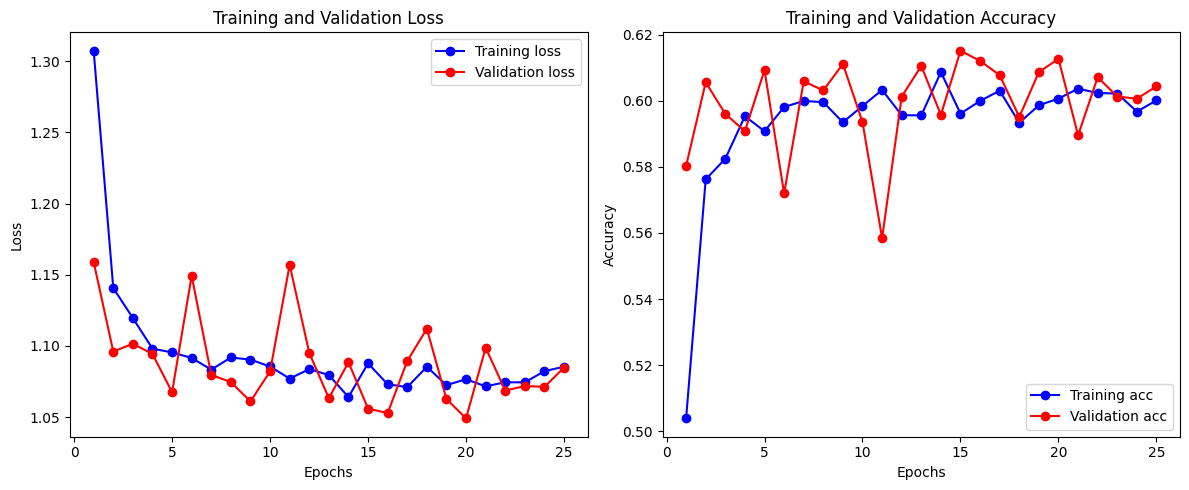

Model saved to mobilenet_custom_dataset.pth
Checkpoint saved to mobilenet_checkpoint_custom.pth


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time
import copy

# 1. Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# 2. Load dataset using ImageFolder
data_dir = '/home/idrone2/Tea_pest/pest-6'  # Replace with your dataset path
full_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms['train'])

# 3. Split the dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Update validation dataset's transform
val_dataset.dataset.transform = data_transforms['val']

# 4. Create dataloaders
batch_size = 32
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

class_names = full_dataset.classes
print(f"Classes: {class_names}")
print(f"Dataset sizes: {dataset_sizes}")

# 5. Define the MobileNetV2 model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.mobilenet_v2(pretrained=True)

# Freeze feature extractor parameters
for param in model.features.parameters():
    param.requires_grad = False

# Modify the classifier
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

# 6. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# 7. Define the training function
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {int(time_elapsed // 60)}m {int(time_elapsed % 60)}s')
    print(f'Best Validation Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)

    metrics = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accuracies,
        'val_acc': val_accuracies
    }
    return model, metrics

# 8. Train the model
num_epochs = 25
model, metrics = train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs)

# 9. Plot metrics
def plot_metrics(metrics, num_epochs):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics['train_loss'], 'bo-', label='Training loss')
    plt.plot(epochs, metrics['val_loss'], 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics['train_acc'], 'bo-', label='Training acc')
    plt.plot(epochs, metrics['val_acc'], 'ro-', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(metrics, num_epochs)

# 10. Save the model
model_save_path = 'mobilenet_custom_dataset.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Optional: Save a checkpoint
checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_names': class_names,
    'metrics': metrics
}

checkpoint_path = 'mobilenet_checkpoint_custom.pth'
torch.save(checkpoint, checkpoint_path)
print(f"Checkpoint saved to {checkpoint_path}")
